In [1]:
import numpy as np
import pandas as pd
import os, re, math, platform
from pathlib import Path
import matplotlib.pyplot as plt
import json
import joblib
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score
from imblearn.metrics import geometric_mean_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier 
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis as PA
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
from matplotlib import pyplot
from sklearn.metrics import matthews_corrcoef, confusion_matrix,precision_recall_curve, roc_curve, auc, fbeta_score,roc_auc_score
from fea_extract import read_fasta,insert_AAC,insert_DPC,insert_CKSAAGP,insert_CTD,insert_PAAC,insert_AAI,insert_GTPC,insert_QSO,insert_AAE,insert_PSAAC,insert_word2int,insert_ASDC
import warnings 
from tools import cv,evaluate
warnings.filterwarnings('ignore')

In [2]:
seed = 10
Path('./results/evalue/').mkdir(exist_ok=True,parents=True)
Path('./results/evalue_balance/').mkdir(exist_ok=True,parents=True)

In [4]:
GBDT = GradientBoostingClassifier(random_state=seed)
ET = ExtraTreesClassifier(random_state=seed)
SVM = SVC(random_state=seed,probability=True)
MLP = MLPClassifier(hidden_layer_sizes=32,learning_rate="adaptive",random_state=seed)
RF = RandomForestClassifier(random_state=seed)
XGBoost = XGBClassifier(random_state=seed)
LR  = LogisticRegression(random_state=seed)
AB = AdaBoostClassifier(random_state=seed)
clf_feature_order = {
    "AAC": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
    "PAAC": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
    "CKSAAGP": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
#     "PSAAC": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
    "DPC": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
    "GTPC": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
    "QSO": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
#     "AAE": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
#     "AAI": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
    "ASDC": ["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
    "CTD" :["XGBoost","RF","ET","SVM","MLP","GBDT","AB"],
    "All_data" :["XGBoost","RF","ET","SVM","MLP","GBDT","AB"]
}

###### 5折交叉验证进行试验

In [5]:
index = []
ALL_evals = pd.DataFrame()
for (n,m) in clf_feature_order.items():
    print('process_{}'.format(n))
    X = pd.read_csv('results/process_data/train_{}.csv'.format(n))
    feature = X.columns[2:]
    X_ = X[feature] .to_numpy()
    Y_ = pd.read_csv('data/train/y_train.csv').to_numpy()
    #打乱数据
    np.random.seed(1234)
    idx = np.random.permutation(len(X_))
    X_ = X_[idx]
    Y_ = Y_[idx]
    for i in m:
        model = eval(i)
        Evals = cv(model,X_,Y_)
        ALL_evals = pd.concat([ALL_evals,Evals],axis=1)
        index.append('{}_{}'.format(n,i))
ALL_evals.columns=index

process_AAC
process_PAAC
process_CKSAAGP
process_DPC
process_GTPC
process_QSO
process_ASDC
process_CTD
process_All_data


In [6]:
#针对测试集五折交叉验证
def cv_test(model,df_X_train,df_y_train,df_X_test,df_y_test,n_folds=5):
    eval_dict = []
    kf = KFold(n_splits=5, shuffle=True, random_state=10)#K-折叠交叉验证。
    for train_index, test_index in kf.split(df_X_train, df_y_train):
        X_train_ = df_X_train[train_index]
        y_train_ = df_y_train[train_index]
        model.fit(X_train_,y_train_)
        eval_dictionary = evaluate(df_X_test,df_y_test,model)
        eval_dict = eval_dict+[eval_dictionary]
    evals = pd.DataFrame(eval_dict).mean()
    Evals = pd.DataFrame(evals)
    return Evals

In [8]:
index = []
ALL_evals_test = pd.DataFrame()
for (n,m) in clf_feature_order.items():
    print('process_{}'.format(n))
    X_train = pd.read_csv('results/process_data/train_{}.csv'.format(n))
    X_test = pd.read_csv('results/process_data/test_{}.csv'.format(n))
    feature = X_train.columns[2:]
    x_train = X_train[feature] .to_numpy()
    x_test = X_test[feature].to_numpy()
    y_train = pd.read_csv('data/train/y_train.csv').to_numpy()
    y_test = pd.read_csv('data/test/y_test.csv').to_numpy()
    #打乱数据
#     np.random.seed(1234)
#     idx_test = np.random.permutation(len(x_test))
#     idx_train = np.random.permutation(len(x_train))
#     x_test1 = x_test[idx_test]
#     y_test1 = y_test[idx_test]
#     x_train1 = x_train[idx_train]
#     y_train1 = y_train[idx_train]
    for i in m:
        eval_dict=[]
        model = eval(i)
        Evals = cv_test(model,x_train,y_train,x_test,y_test)
        ALL_evals_test = pd.concat([ALL_evals_test,Evals],axis=1)
        index.append('{}_{}'.format(n,i))
ALL_evals_test.columns=index

process_AAC
process_PAAC
process_CKSAAGP
process_DPC
process_GTPC
process_QSO
process_ASDC
process_CTD
process_All_data


In [7]:
ALL_evals.to_csv("results/evalue/select_encodings_ML.csv")

In [9]:
ALL_evals_test.to_csv("results/evalue/select_encodings_ML_test.csv")

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
data_eval = pd.read_excel('results/evalue/AUC_ML_encod.xlsx',index_col=0,sheet_name='Sheet2')

In [14]:
data_eval = data_eval.loc['Average'].T

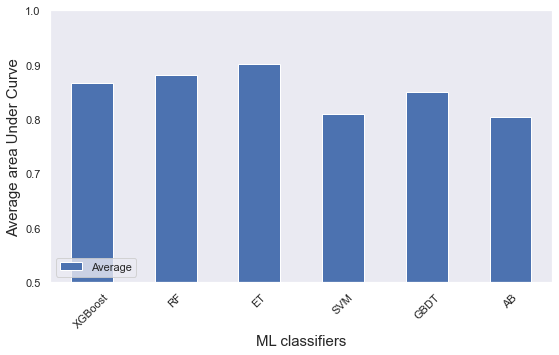

In [21]:
sns.set()
data_eval.plot.bar(figsize=(9,5),rot=45,width = 0.5,grid = False)
plt.ylim(0.50,1.0)
plt.ylabel('Average area Under Curve',fontsize=15)
plt.xlabel('ML classifiers',fontsize=15)
plt.legend(loc =  'lower left' )

In [2]:
data_eval = pd.read_excel('results/evalue/AUC_ML_encod.xlsx',index_col=0,sheet_name='Sheet2').T

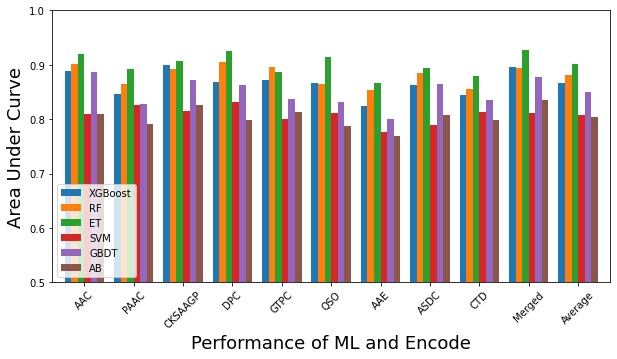

In [4]:

data_eval.plot.bar(figsize=(10,5),rot=45,width = 0.8,grid = False)
plt.ylim(0.50,1.0)
plt.ylabel('Area Under Curve',fontsize=18)
plt.xlabel('Performance of ML and Encode',fontsize=18)
plt.legend(loc =  'lower left' )

In [10]:
from skimage import transform,data
import matplotlib.pyplot as plt
import numpy as np

In [17]:
a = [2,5,8,4,3,8,7,1]
b = np.array(a).reshape(8,1)

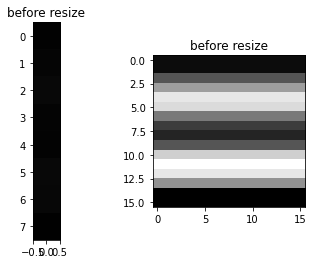

In [22]:
dst=transform.resize(b, (16, 16))
plt.figure('resize')

plt.subplot(121)
plt.title('before resize')
plt.imshow(c,plt.cm.gray)

plt.subplot(122)
plt.title('before resize')
plt.imshow(dst,plt.cm.gray)

plt.show()

In [25]:
print(b.shape)
print(b)
print(dst.shape)
print(dst)

(8, 1)
[[2]
 [5]
 [8]
 [4]
 [3]
 [8]
 [7]
 [1]]
(16, 16)
[[1.51339918e-09 1.51339918e-09 1.51339918e-09 1.51339918e-09
  1.51339918e-09 1.51339918e-09 1.51339918e-09 1.51339918e-09
  1.51339918e-09 1.51339918e-09 1.51339918e-09 1.51339918e-09
  1.51339918e-09 1.51339918e-09 1.51339918e-09 1.51339918e-09]
 [1.51339918e-09 1.51339918e-09 1.51339918e-09 1.51339918e-09
  1.51339918e-09 1.51339918e-09 1.51339918e-09 1.51339918e-09
  1.51339918e-09 1.51339918e-09 1.51339918e-09 1.51339918e-09
  1.51339918e-09 1.51339918e-09 1.51339918e-09 1.51339918e-09]
 [2.21189112e-09 2.21189112e-09 2.21189112e-09 2.21189112e-09
  2.21189112e-09 2.21189112e-09 2.21189112e-09 2.21189112e-09
  2.21189112e-09 2.21189112e-09 2.21189112e-09 2.21189112e-09
  2.21189112e-09 2.21189112e-09 2.21189112e-09 2.21189112e-09]
 [2.91038305e-09 2.91038305e-09 2.91038305e-09 2.91038305e-09
  2.91038305e-09 2.91038305e-09 2.91038305e-09 2.91038305e-09
  2.91038305e-09 2.91038305e-09 2.91038305e-09 2.91038305e-09
  2.910383

###### 选取Word2int与ET

###### 对平衡数据集进行处理

In [5]:
index = []
ALL_evals = pd.DataFrame()
for (n,m) in clf_feature_order.items():
    print('process_{}'.format(n))
    X = pd.read_csv('results/balance/train_{}.csv'.format(n))
    feature = X.columns[2:]
    X_ = X[feature] .to_numpy()
    Y_ = pd.read_csv('data/processdata/blearn_y.csv').to_numpy()
    for i in m:
        model = eval(i)
        Evals = cv(model,X_,Y_)
        ALL_evals = pd.concat([ALL_evals,Evals],axis=1)
        index.append('{}_{}'.format(n,i))
ALL_evals.columns=index

process_AAC
process_PAAC
process_CKSAAGP
process_PSAAC
process_DPC
process_GTPC
process_QSO
process_AAE
process_AAI
process_ASDC
process_word2int
process_CTD


In [13]:
ALL_evals.to_csv("results/evalue_balance/select_encodings_ML.csv",index = False)

###### 画图

In [31]:
data = pd.read_excel('results/evalue/AUC_ML_encod.xlsx',index_col=0,sheet_name='Sheet2').T

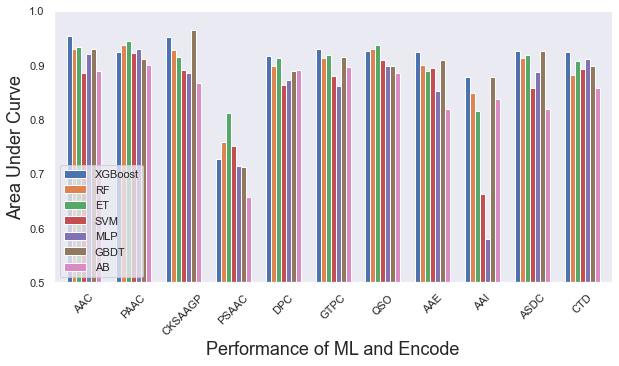

In [32]:
sns.set()
data.plot.bar(figsize=(10,5),rot=45,width = 0.7,grid = False)
plt.ylim(0.50,1.0)
plt.ylabel('Area Under Curve',fontsize=18)
plt.xlabel('Performance of ML and Encode',fontsize=18)
plt.legend(loc =  'lower left' )